In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
np.set_printoptions(threshold=sys.maxsize)

from PIL import Image
import time

import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset , DataLoader
from torch import nn
from torch import optim
import torch.nn.functional as F

from tqdm import tqdm


In [2]:
# Loading the data given for the Task - 1 
train_data = np.load("../data/train/imgs-001.npy")
labels = np.load("../data/train/known_values_labels.npy")

In [3]:
print(f'Train Data shape: {train_data.shape}')
print(f'Labels shape : {labels.shape}')

Train Data shape: (50000, 252, 252)
Labels shape : (50000, 41, 3)


##### Train Data has 50000 images with 252 pixels each
##### Label Data has 50000 labels for given images , each label has 41 rows with 3 columns of row,col,actual_digit in the train image

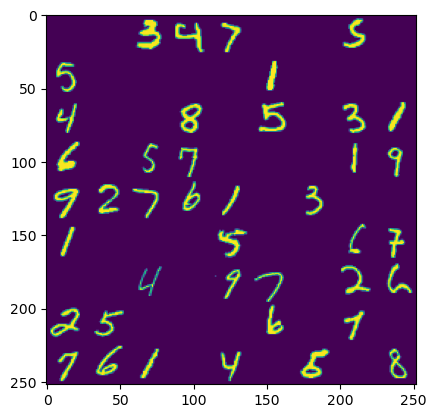

In [4]:
# plotting the first train image
plt.imshow(train_data[0]);

In [5]:
# Function to get the digit at a particular row and column
def get_digit_image_from_grid(sudoku_image, row, column, digit_size=28):
    # Calculate the coordinates for the specified digit
    left = column * digit_size
    upper = row * digit_size
    right = left + digit_size
    lower = upper + digit_size
    
    return  sudoku_image[upper:lower, left:right]

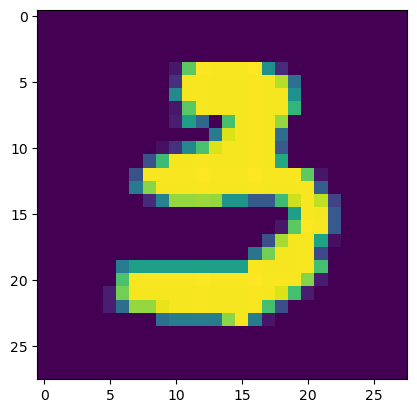

In [6]:
# Checking the Function to get the digit from the sudoku image
row = 0
column = 2

digit_array = get_digit_image_from_grid(train_data[0], row, column)
plt.imshow(digit_array)

There are 41 rows with row,col and the respective digit in that particular row and column

In [7]:
train_data.shape[0]

50000


- These are going to create the dataset of single images from our filled trained grids and the label information

In [8]:
# Creating a dataset of images from the given sudoku grid images and the labels
# Total 50000 images with each 41 digits filled. Hence 50000*41 = 2050000
all_single_images = []
all_single_labels = []

start_time = time.time()

for image_idx in range(train_data.shape[0]):
    for row, column, label in labels[image_idx]:
        digit = get_digit_image_from_grid(train_data[image_idx], int(row), int(column))
        all_single_images.append(digit)
        all_single_labels.append(int(label))

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Total time taken: {elapsed_time} seconds")

Total time taken: 8.310198783874512 seconds


In [9]:
print(f' Shape of All Single digits : {len(all_single_images)}')
print(f' Shape of ALl Single digits labels : {len(all_single_labels)}')

 Shape of All Single digits : 2050000
 Shape of ALl Single digits labels : 2050000


In [10]:
# Saving individual digits into a numpy array to train the model
all_single_images_array = np.array(all_single_images)
np.save('../data/train/processed/all_single_images.npy', all_single_images_array)

In [11]:
all_single_labels_array = np.array(all_single_labels)
np.save('../data/train/processed/all_single_labels.npy', all_single_labels_array)

The images and labels are now separated into a new dataset which will be used to train the model now to predict

# Model Building  Task -1 :  ANN

In [12]:
# load images and labels which are created separately from the given dataset
images = np.load('../data/train/processed/all_single_images.npy')
labels = np.load('../data/train/processed/all_single_labels.npy')

In [13]:
split = int(images.shape[0]*0.80)

train_images = images[:split]
train_labels = labels[:split]

test_images = images[split:]
test_labels = labels[split:]

In [14]:
train_images.shape

(1640000, 28, 28)

In [15]:
test_images.shape

(410000, 28, 28)

In [16]:
print(f'Train images size: {train_images.shape} and Train labels size : {train_labels.shape}')
print(f'Test images size: {test_images.shape} and Test labels size : {test_labels.shape}')

Train images size: (1640000, 28, 28) and Train labels size : (1640000,)
Test images size: (410000, 28, 28) and Test labels size : (410000,)


In [17]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return image, label

In [18]:
train_dataset = CustomDataset(train_images, train_labels, transform=transforms.ToTensor())

train_dataset.labels = torch.tensor(train_dataset.labels, dtype=torch.long)

test_dataset = CustomDataset(test_images, test_labels, transform=transforms.ToTensor())

test_dataset.labels = torch.tensor(test_dataset.labels, dtype=torch.long)

train_loader = DataLoader(train_dataset, batch_size=500, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=500, shuffle=False)

In [19]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_dims):
        super(MLP, self).__init__()
        layers = []

        layers.append(nn.Linear(input_size, hidden_dims[0]))
        layers.append(nn.ReLU())
        
        for i in range(len(hidden_dims) - 1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i + 1]))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(hidden_dims[-1], 10))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [20]:
input_size = 28 * 28

mlp_model = MLP(input_size, hidden_dims=[256, 128, 64, 32])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp_model.to(device)
print(mlp_model)

optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

MLP(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=10, bias=True)
  )
)


Epoch: 1/5  Training loss: 0.0791  Training accuracy: 0.9762  Testing loss: 0.0071  Testing accuracy: 0.9975
Epoch: 2/5  Training loss: 0.0031  Training accuracy: 0.9990  Testing loss: 0.0000  Testing accuracy: 1.0000
Epoch: 3/5  Training loss: 0.0000  Training accuracy: 1.0000  Testing loss: 0.0000  Testing accuracy: 1.0000
Epoch: 4/5  Training loss: 0.0000  Training accuracy: 1.0000  Testing loss: 0.0000  Testing accuracy: 1.0000
Epoch: 5/5  Training loss: 0.0000  Training accuracy: 1.0000  Testing loss: 0.0000  Testing accuracy: 1.0000


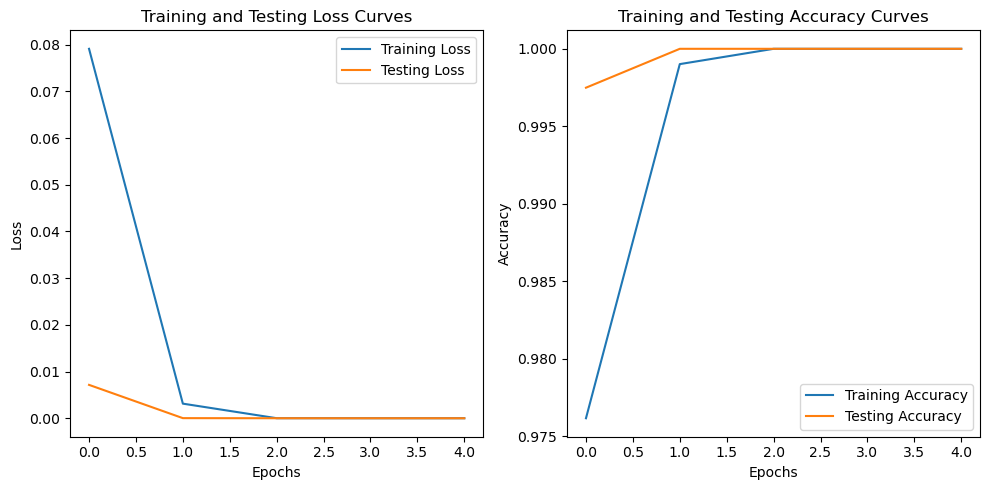

In [21]:
epochs = 5
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    mlp_model.train()
    train_loss = 0
    correct_train_predictions = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        images = images.view(images.size(0), -1)
        output = mlp_model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.data.item() * images.size(0)

        _, predicted = torch.max(output.data, 1)
        correct_train_predictions += (predicted == labels).sum().item()

    train_accuracy = correct_train_predictions / len(train_loader.dataset)
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss / len(train_loader.dataset))

    # Testing loop
    mlp_model.eval()
    test_loss = 0
    correct_test_predictions = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            images = images.view(images.size(0), -1)
            log_probabilities = mlp_model(images)
            test_loss += criterion(log_probabilities, labels).item() * images.size(0)

            _, predicted = torch.max(log_probabilities, 1)
            correct_test_predictions += (predicted == labels).sum().item()

    test_accuracy = correct_test_predictions / len(test_loader.dataset)
    test_accuracies.append(test_accuracy)
    test_losses.append(test_loss / len(test_loader.dataset))

    print(f"Epoch: {epoch + 1}/{epochs}  "
          f"Training loss: {train_losses[-1]:.4f}  "
          f"Training accuracy: {train_accuracy:.4f}  "
          f"Testing loss: {test_losses[-1]:.4f}  "
          f"Testing accuracy: {test_accuracy:.4f}")

# Plotting the loss and accuracy curves
plt.figure(figsize=(10, 5))

# Plotting the loss curves
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Curves')

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Testing Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy Curves')

plt.tight_layout()
plt.show()

In [22]:
model_path = 'mlp_fully_trained.pth'
torch.save(mlp_model, model_path)

# Making the Predictions for Test images 

In [23]:
# create test_images
test = np.load('../data/test/imgs.npy')

In [24]:
test_preds_per_image_ids = []
test_preds_per_image_values = []

mlp_model.eval()
for image_idx in range(test.shape[0]):
     #plt.imshow(test[image_idx])
    for row in range(0,9):
        for col in range(0,9):
                test_image = get_digit_image_from_grid(test[image_idx], row , col)
                img = np.array(test_image)
                img = torch.tensor(img,  dtype=torch.float32)
                img = img.to(device)
                with torch.no_grad():
                    is_zero = torch.all(img == 0).item()
                    if is_zero:
                        pred = 0
                        #print(pred)
                    else : 
                        img = img.view(1,-1)
                        logits = mlp_model(img)
                        probabilities = F.softmax(logits, dim=1).detach().cpu().numpy().squeeze()
                        pred = np.argmax(probabilities)
                id = str(image_idx)+'_' + str(row) + str(col)
                test_preds_per_image_ids.append(id)
                test_preds_per_image_values.append(pred)

In [25]:
mlp_results = pd.DataFrame({'id': test_preds_per_image_ids , 'values' : test_preds_per_image_values})
mlp_results

,id,values
0,0_00,2
1,0_01,0
2,0_02,7
3,0_03,0
4,0_04,1
...,...,...
809995,9999_84,3
809996,9999_85,5
809997,9999_86,2
809998,9999_87,0


In [27]:
mlp_results.to_csv('mlp_trained_submission.csv', index = False)

# CNN Approach

In [28]:
# load images and labels
original_images = np.load('../data/train/processed/all_single_images.npy')
original_labels = np.load('../data/train/processed/all_single_labels.npy')

In [29]:
split = int(original_images.shape[0]*0.80)
train_images = original_images[:split]
train_labels = original_labels[:split]

test_images = original_images[split:]
test_labels = original_labels[split:]

In [30]:
train_images.shape , train_labels.shape

((1640000, 28, 28), (1640000,))

In [31]:
test_images.shape , test_labels.shape

((410000, 28, 28), (410000,))

In [32]:
train_dataset = CustomDataset(train_images, train_labels, transform=transforms.ToTensor())

train_dataset.labels = torch.tensor(train_dataset.labels, dtype=torch.long)

test_dataset = CustomDataset(test_images, test_labels, transform=transforms.ToTensor())

test_dataset.labels = torch.tensor(test_dataset.labels, dtype=torch.long)

train_loader = DataLoader(train_dataset, batch_size=500, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=500, shuffle=False)

In [33]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return image, label

In [34]:
training_data = enumerate(train_loader)
batch_idx, (images, labels) = next(training_data)
print(type(images)) # Checking the datatype 
print(images.shape) # the size of the image
print(labels.shape) # the size of the labels

<class 'torch.Tensor'>
torch.Size([500, 1, 28, 28])
torch.Size([500])


In [35]:
class CNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNN, self).__init__()

        # Layer 1
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        # Layer 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        # Fully connected layer
        self.fc1 = nn.Linear(4 * 4 * 64, num_classes)

    def forward(self, x):
        x = self.maxpool1(self.relu1(self.conv1(x)))
        x = self.maxpool2(self.relu2(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [36]:
cnn_model = CNN(input_size=(1, 28, 28), num_classes=10).to(device)
print(cnn_model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=10, bias=True)
)


Epoch [1/5], Training Loss: 0.0403, Training Accuracy: 0.9886, Testing Loss: 0.0097, Testing Accuracy: 0.9966


Epoch [2/5], Training Loss: 0.0022, Training Accuracy: 0.9994, Testing Loss: 0.0022, Testing Accuracy: 0.9993


Epoch [3/5], Training Loss: 0.0001, Training Accuracy: 1.0000, Testing Loss: 0.0000, Testing Accuracy: 1.0000


Epoch [4/5], Training Loss: 0.0012, Training Accuracy: 0.9997, Testing Loss: 0.0000, Testing Accuracy: 1.0000


Epoch [5/5], Training Loss: 0.0000, Training Accuracy: 1.0000, Testing Loss: 0.0000, Testing Accuracy: 1.0000


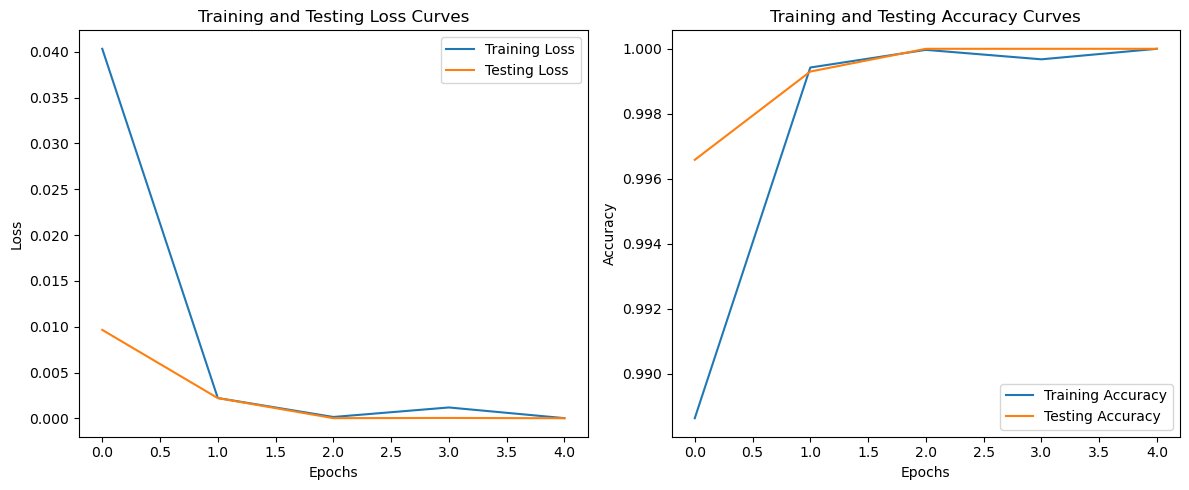

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

# Training loop
num_epochs = 5
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    # Training
    cnn_model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_samples = 0

    
    with tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} (Training)", leave=False) as tqdm_train:
        for images, labels in tqdm_train:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = cnn_model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            correct_train_predictions += (predicted == labels).sum().item()

            
            tqdm_train.set_postfix(train_loss=running_loss / len(train_loader),
                                   train_accuracy=correct_train_predictions / total_train_samples)

    train_accuracy = correct_train_predictions / total_train_samples
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Testing
    cnn_model.eval()
    running_test_loss = 0.0
    correct_test_predictions = 0
    total_test_samples = 0

    
    with tqdm(test_loader, desc=f"Epoch {epoch + 1}/{num_epochs} (Testing)", leave=False) as tqdm_test:
        with torch.no_grad():
            for images, labels in tqdm_test:
                images, labels = images.to(device), labels.to(device)

                outputs = cnn_model(images)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                correct_test_predictions += (predicted == labels).sum().item()

                
                tqdm_test.set_postfix(test_loss=running_test_loss / len(test_loader),
                                      test_accuracy=correct_test_predictions / total_test_samples)

    test_accuracy = correct_test_predictions / total_test_samples
    test_losses.append(running_test_loss / len(test_loader))
    test_accuracies.append(test_accuracy)

    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Training Loss: {train_losses[-1]:.4f}, "
          f"Training Accuracy: {train_accuracy:.4f}, "
          f"Testing Loss: {test_losses[-1]:.4f}, "
          f"Testing Accuracy: {test_accuracy:.4f}")


plt.figure(figsize=(12, 5))

# Plotting the loss curves
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Curves')

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Testing Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy Curves')

plt.tight_layout()
plt.show()

In [39]:
model_path = 'cnn_fully_trained.pth'
torch.save(cnn_model, model_path)

# making predictions with CNN model

In [40]:
test = np.load('../data/test/imgs.npy')

In [41]:
test_preds_per_image_ids = []
test_preds_per_image_values = []

cnn_model.eval()

start_time = time.time()

for image_idx in range(test.shape[0]):
    for row in range(0, 9):
        for col in range(0, 9):
            test_image = get_digit_image_from_grid(test[image_idx], row, col)
            img = np.array(test_image)
            img = torch.tensor(img, dtype=torch.float32)
            img = img.to(device)
            #print(img.shape)
            with torch.no_grad():
                is_zero = torch.all(img == 0).item()
                if is_zero:
                    pred = 0
                else:
                    img = img.view(1,1, 28,28)
                    #print(img.shape)
                    logits = cnn_model(img)
                    probabilities = F.softmax(logits, dim=1).detach().cpu().numpy().squeeze()
                    pred = np.argmax(probabilities)

            id = str(image_idx) + '_' + str(row) + str(col)
            test_preds_per_image_ids.append(id)
            test_preds_per_image_values.append(pred)

end_time = time.time()  
elapsed_time = end_time - start_time

print(f"Total time taken: {elapsed_time:.2f} seconds")

Total time taken: 638.41 seconds


In [42]:
results_cnn = pd.DataFrame({'id': test_preds_per_image_ids , 'values' : test_preds_per_image_values})
results_cnn

,id,values
0,0_00,2
1,0_01,0
2,0_02,7
3,0_03,0
4,0_04,1
...,...,...
809995,9999_84,3
809996,9999_85,5
809997,9999_86,2
809998,9999_87,0


In [43]:
results_cnn.to_csv('cnn_trained_submission.csv', index = False)